## Todos

auf git comitten (mit reqirements.txt)
in methode auslagern
data download script
blog artikel

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.preprocessing import MinMaxScaler
import requests

/Users/Nicolas/anaconda3/envs/DSfromScratch/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

# Predicting the house price by regression model

## Data Import

In [3]:
# The direct link to the Kaggle data set
data_url_train = 'https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/train.csv'

# The local path where the data set is saved.
local_filename_train = "train.csv"

# Kaggle Username and Password
kaggle_info = {'UserName': "my_username", 'Password': "my_password"}

# Attempts to download the CSV file. Gets rejected because we are not logged in.
r = requests.get(data_url_train)

# Login to Kaggle and retrieve the data.
r = requests.post(r.url, data = kaggle_info, prefetch = False)

# Writes the data to a local file one chunk at a time.
f = open(local_filename, 'w')
for chunk in r.iter_content(chunk_size = 512 * 1024): # Reads 512KB at a time into memory
    if chunk: # filter out keep-alive new chunks
        f.write(chunk)
f.close()

In [4]:
df_train.sample(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
754,755,20,RL,61.0,7930,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,156000


## Data Splitting

In [5]:
#check the numbers of samples and features
print("train data size before dropping Id feature: {} ".format(df_train.shape))
print("test data size before dropping Id feature: {} ".format(df_test.shape))

train data size before dropping Id feature: (1460, 81) 
test data size before dropping Id feature: (1459, 80) 


In [6]:
#Save df and test ID
train_ID = df_train['Id']
test_ID = df_test['Id']

#safe features
feature_names = list(df_train)

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop('Id', axis = 1, inplace = True)
#df_test.drop('Id', axis = 1, inplace = True)

In [12]:
#preprocess train and test
train = data_preprocess(df_train)
test = data_preprocess(df_test)

In [13]:
#Check the numbers of samples and features after drop 'Id'
print("train data size after dropping Id feature: {} ".format(df_train.shape))
print("test data size after dropping Id feature: {} ".format(df_test.shape))

train data size after dropping Id feature: (1460, 80) 
test data size after dropping Id feature: (1459, 80) 


## Analyze the data

In [ ]:
sns.scatterplot(train['GrLivArea'], train['SalePrice'])

## Data Preprocessing

In [7]:
def data_preprocess(df):
    if 'SalePrice' in df:
        df = log_target(df)
        df = remove_outlier(df)
    df = remove_nans(df)
    df = feature_engineering(df)
    return df

In [8]:
def log_target(df):
    #show the distribution of the target
    
    #log1n the target 'SalePrice'
    df["SalePrice"] = np.log1p(df["SalePrice"])
    
    #sns.distplot(df['SalePrice'])
    
    return df

### Remove outliers

In [9]:
def remove_outlier(df):  
    #Check the GrLivArea of the houses to find outliers
    #sns.scatterplot(df['GrLivArea'], df['SalePrice'])
    
    #Remove 'GrLivArea' Outliers over 4000 square feet because there are two outliers
    df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
    
    #Check the LotArea of the houses to find outliers
    #sns.scatterplot(df['LotArea'], df['SalePrice'])
    
    #Remove 'LotArea' Outliers over 100000 square feet because there are four outliers
    df = df.drop(df[(df['LotArea']>100000)].index)
    
    return df

### Handling Missing Values

In [10]:
def remove_nans(df):
    #get the % of missing values
    missing_values = (df.isnull().sum()/len(df))*100

    #make a df
    missing_values_df = pd.DataFrame({'percent_missing': missing_values})

    #sort df by 'percent_missing' in descending order and 
    missing_values_df.sort_values('percent_missing', inplace = True, ascending = False)

    #store > 0 in missing_values_above_zero
    missing_values_above_zero = missing_values_df[missing_values_df['percent_missing']>0]

    #plot 'percent_missing'
    #plot = sns.barplot(missing_values_above_zero.index, missing_values_above_zero['percent_missing'])
    #plot.set(xlabel='Features')
    #for item in plot.get_xticklabels():
        #item.set_rotation(45)
        
    #1. PoolQC -> NA means no Pool (data description) -> fill with "None"
    df['PoolQC'] = df['PoolQC'].fillna("None")

    #2. MiscFeature -> NA means no other feature that is covered by a feature (data description) -> fill with "None"
    df['MiscFeature'] = df['MiscFeature'].fillna("None")

    #3. Alley -> NA means no access to alley (data description) -> fill with "None"
    df['Alley'] = df['Alley'].fillna("None")

    #4. Fence -> NA means no fence (data description) -> fill with "None"
    df['Fence'] = df['Fence'].fillna("None")

    #5. FireplaceQu -> NA means no FireplaceQu (data description) -> fill with "None"
    df['FireplaceQu'] = df['FireplaceQu'].fillna("None")

    #6. LotFrontage -> missing LotFrontage could be filled with the median of the neighboors LotFrontage
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    #7. Garage String Features -> if missing than no garage (data description) -> fill with "None"
    for col in ('GarageCond','GarageFinish','GarageQual','GarageType'):
        df[col] = df[col].fillna("None")

    #8. Garage Number Features
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna("None")

    #9. Bsmt Features -> if NA than there is no Basement (data description) -> fill with "None"
    for col in ('BsmtCond','BsmtFinType2','BsmtQual','BsmtExposure','BsmtFinType1'):
        df[col] = df[col].fillna("None")

    #10. MasVnrType -> if NA than there is no MasVnr (data description) -> fill with "None"
    df['MasVnrType'] = df['MasVnrType'].fillna("None")
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    #11. Electrical -> fill NA with SBrKr because most of the Values are that (>90%)
    df['Electrical'] = df['Electrical'].fillna('SBrKr')

    for n,c in df.items():
        if df[n].dtype=='object' or df[n].dtype=='str': 
            df[n] = pd.Categorical(df[n])
            df[n] = df[n].cat.codes
            
    return df

## Feature Engineering

In [11]:
def feature_engineering(df):   
    #create new Feature 'LivingArea' by SUM 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'
    df['TotalArea'] = df['GrLivArea'] + df['1stFlrSF'] + df['1stFlrSF']
    return df

In [14]:
#Split features and targets for creating a validation dataset
#X_train = train.loc[:, train.columns != 'SalePrice']
#y_train = train['SalePrice'].values

X = train.loc[:, train.columns != 'SalePrice']
y = train['SalePrice'].values

# train and valid split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_test = test

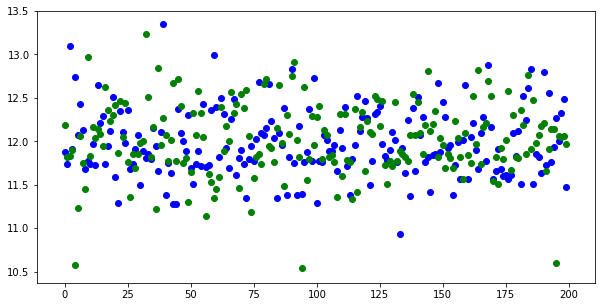

In [15]:
#Show the distribution of df and validation dataset
indices = [ x for x in range(0, len(X_test))]
plt.scatter(indices[:200], y_train[:200],  color='blue')
plt.scatter(indices[:200], y_test[:200], color='green')

## 4. linear regression

In [16]:
reg = linear_model.LinearRegression()

In [17]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
y_pred = reg.predict(X_test)

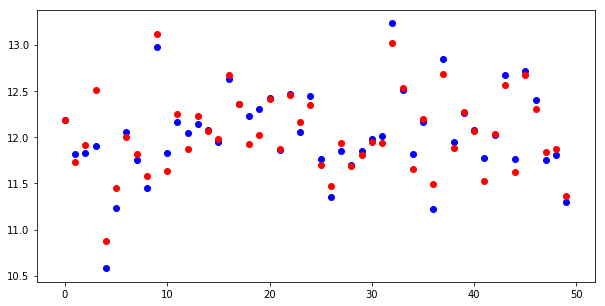

In [19]:
plt.scatter(indices[:50], y_test[:50],  color='blue')
plt.scatter(indices[:50], y_pred[:50], color='red')

In [22]:
print(rmse(y_pred, y_test))

0.12819161676341578


In [23]:
columns = X_train.columns
coefs = reg.coef_

## 5. random forest regressor

In [ ]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=100, min_samples_split=2, min_samples_leaf=2,max_features=0.5)

In [ ]:
m.fit(X_train, y_train)

In [ ]:
pred_rf = m.predict(X_test)

In [ ]:
rmse(pred_rf, y_test)

# usefull stuff

In [ ]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [21]:
def rmse(y_pred, y_valid):
    rmse = (sqrt(metrics.mean_squared_error(y_pred, y_valid)))
    return(rmse)

In [ ]:
def remove_correlated_variables(data, columns, inplace = False):
    # calculate the correlation matrix for the features only
    df_corr = data.corr(method='spearman')
    # create a mask to ignore self-correlation
    mask = np.ones(df_corr.columns.size) - np.eye(df_corr.columns.size)
    df_corr = mask * df_corr
    
    drops = []
    # loop through each variable, drop the target from analysis though
    for col in df_corr.columns.values:
        # if we've already determined to drop the current variable, continue
        if np.isin([col], drops):
            continue
        # find all the variables that are highly correlated with the current variable
        # and add them to the drop list
        corr = df_corr[abs(df_corr[col]) > 0.8].index #remove all above 0.9x correlation-we varied x for tests
        drops = np.union1d(drops, corr)
    
    print("\nDropping", drops.shape[0], "highly correlated features...n", drops)
    return data.drop(drops, axis=1, inplace=inplace)